In [1]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for the models
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load dataset
dataset = datasets.ImageFolder(root='/kaggle/input/gallbladder/Gallblader Diseases Dataset', transform=transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = len(dataset.classes)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained VGG16 model
import torch.nn as nn
from torchvision import models
vgg = models.vgg16(pretrained=True)

# Freeze parameters
for param in vgg.parameters():
    param.requires_grad = False

# Modify the classifier
num_classes = len(dataset.classes)  # Get number of classes
vgg.classifier[6] = nn.Linear(4096, num_classes)
vgg = vgg.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 221MB/s]


In [5]:
# Load pre-trained Inception model
inception = models.inception_v3(pretrained=True)

# Modify the final layer to match the number of classes
inception.fc = nn.Linear(inception.fc.in_features, num_classes)
inception = inception.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 207MB/s] 


In [6]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_model(model, train_loader, test_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    test_accuracies = []
    epoch_times = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Testing phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
        
        test_loss = running_loss / len(test_loader)
        test_losses.append(test_loss)
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        # Time per epoch
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
        report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1_score = report['weighted avg']['f1-score']
    
    return train_losses, test_losses, test_accuracies, epoch_times, all_labels, all_preds, {
        'model_name': model,
        'train_loss': train_losses[-1],  # Loss from the last epoch
        'test_loss': test_losses[-1],    # Loss from the last epoch
        'accuracy': test_accuracies[-1], # Accuracy from the last epoch
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'time_per_epoch': sum(epoch_times) / num_epochs # Average time per epoch
    }




In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_losses(train_losses_resnet, test_losses_resnet, train_losses_vgg, test_losses_vgg, train_losses_inception, test_losses_inception):
    plt.figure(figsize=(14, 7))

    # Train Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses_resnet, label='ResNet Train Loss', linestyle='-', marker='o', markersize=4)
    plt.plot(train_losses_vgg, label='VGG Train Loss', linestyle='--', marker='s', markersize=4)
    plt.plot(train_losses_inception, label='Inception Train Loss', linestyle=':', marker='^', markersize=4)
    
    # Highlight minimum and maximum losses
    plt.scatter(np.argmin(train_losses_resnet), min(train_losses_resnet), color='red', label='Min ResNet Loss')
    plt.scatter(np.argmax(train_losses_resnet), max(train_losses_resnet), color='blue', label='Max ResNet Loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(True)

    # Test Losses
    plt.subplot(1, 2, 2)
    plt.plot(test_losses_resnet, label='ResNet Test Loss', linestyle='-', marker='o', markersize=4)
    plt.plot(test_losses_vgg, label='VGG Test Loss', linestyle='--', marker='s', markersize=4)
    plt.plot(test_losses_inception, label='Inception Test Loss', linestyle=':', marker='^', markersize=4)
    
    # Highlight minimum and maximum losses
    plt.scatter(np.argmin(test_losses_resnet), min(test_losses_resnet), color='red', label='Min ResNet Loss')
    plt.scatter(np.argmax(test_losses_resnet), max(test_losses_resnet), color='blue', label='Max ResNet Loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss Comparison')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [9]:
def plot_accuracy(test_acc_resnet, test_acc_vgg, test_acc_inception):
    plt.figure(figsize=(6, 4))
    plt.plot(test_acc_resnet, label='ResNet Accuracy')
    plt.plot(test_acc_vgg, label='VGG Accuracy')
    plt.plot(test_acc_inception, label='Inception Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Comparison')
    plt.legend()
    plt.show()


In [10]:
def plot_time_per_epoch(time_resnet, time_vgg, time_inception):
    plt.figure(figsize=(6, 4))
    plt.plot(time_resnet, label='ResNet Time')
    plt.plot(time_vgg, label='VGG Time')
    plt.plot(time_inception, label='Inception Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Training Time per Epoch')
    plt.legend()
    plt.show()


In [11]:
def plot_confusion_matrix(labels, preds, classes, model_name,figsize=(1000,30)):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
#         # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()



In [12]:
import torch
import time
from sklearn.metrics import classification_report, confusion_matrix

def train_inception_model(model, train_loader, test_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    test_accuracies = []
    epoch_times = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            # Inception returns two outputs: main output and auxiliary output
            outputs, aux_outputs = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)  # Auxiliary loss
            loss = loss1 + 0.4 * loss2  # Combine losses with weight
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Testing phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)  # Only use the main output in testing
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
        
        test_loss = running_loss / len(test_loader)
        test_losses.append(test_loss)
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        # Time per epoch
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
        
        
        report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1_score = report['weighted avg']['f1-score']
    
    return train_losses, test_losses, test_accuracies, epoch_times, all_labels, all_preds,{
        'model_name': model,
        'train_loss': train_losses[-1],  # Loss from the last epoch
        'test_loss': test_losses[-1],    # Loss from the last epoch
        'accuracy': test_accuracies[-1], # Accuracy from the last epoch
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'time_per_epoch': sum(epoch_times) / num_epochs # Average time per epoch
    }



In [13]:
# Train and test ResNet
train_losses_resnet, test_losses_resnet, test_acc_resnet, time_resnet, labels_resnet, preds_resnet,resnet_resullt = train_model(resnet, train_loader, test_loader)




Epoch [1/5], Train Loss: 1.7616, Test Loss: 2.0703, Accuracy: 31.56%, Time: 281.43s
Epoch [2/5], Train Loss: 1.1742, Test Loss: 1.2598, Accuracy: 56.62%, Time: 195.95s
Epoch [3/5], Train Loss: 0.7066, Test Loss: 1.6868, Accuracy: 55.82%, Time: 202.40s
Epoch [4/5], Train Loss: 0.3496, Test Loss: 0.6788, Accuracy: 79.85%, Time: 197.84s
Epoch [5/5], Train Loss: 0.1911, Test Loss: 0.4043, Accuracy: 85.79%, Time: 198.86s


In [14]:
train_losses_vgg, test_losses_vgg, test_acc_vgg, time_vgg, labels_vgg, preds_vgg, vgg_result = train_model(vgg, train_loader, test_loader,20)


Epoch [1/20], Train Loss: 1.7449, Test Loss: 1.4033, Accuracy: 52.69%, Time: 181.39s
Epoch [2/20], Train Loss: 1.4383, Test Loss: 1.2130, Accuracy: 58.53%, Time: 180.68s
Epoch [3/20], Train Loss: 1.3408, Test Loss: 1.1159, Accuracy: 63.30%, Time: 179.25s
Epoch [4/20], Train Loss: 1.2726, Test Loss: 1.0228, Accuracy: 67.18%, Time: 175.78s
Epoch [5/20], Train Loss: 1.2261, Test Loss: 0.9621, Accuracy: 68.82%, Time: 176.22s
Epoch [6/20], Train Loss: 1.1926, Test Loss: 0.9767, Accuracy: 67.09%, Time: 173.47s
Epoch [7/20], Train Loss: 1.1855, Test Loss: 0.8922, Accuracy: 72.56%, Time: 168.79s
Epoch [8/20], Train Loss: 1.1561, Test Loss: 0.8964, Accuracy: 70.69%, Time: 169.49s
Epoch [9/20], Train Loss: 1.1509, Test Loss: 0.8280, Accuracy: 73.40%, Time: 168.66s
Epoch [10/20], Train Loss: 1.1442, Test Loss: 0.8165, Accuracy: 74.52%, Time: 170.18s
Epoch [11/20], Train Loss: 1.1150, Test Loss: 0.8054, Accuracy: 74.10%, Time: 170.45s
Epoch [12/20], Train Loss: 1.1305, Test Loss: 0.8231, Accuracy:

# inception


In [15]:
import torchvision.transforms as transforms

# Modify your data preprocessing to include resizing to 299x299
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
datasetInc = datasets.ImageFolder(root='/kaggle/input/gallbladder/Gallblader Diseases Dataset', transform=transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_datasetInc, test_datasetInc = random_split(datasetInc, [train_size, test_size])

train_loaderInc = torch.utils.data.DataLoader(train_datasetInc, batch_size=32, shuffle=True)
test_loaderInc = torch.utils.data.DataLoader(test_datasetInc, batch_size=32, shuffle=False)


In [16]:
# Train and test Inception

train_losses_inception, test_losses_inception, test_acc_inception, time_inception, labels_inception, preds_inception,result_inception = train_inception_model(inception, train_loaderInc, test_loaderInc)


Epoch [1/5], Train Loss: 1.8283, Test Loss: 1.0726, Accuracy: 65.54%, Time: 238.30s
Epoch [2/5], Train Loss: 0.7213, Test Loss: 0.5579, Accuracy: 80.74%, Time: 237.69s
Epoch [3/5], Train Loss: 0.3762, Test Loss: 0.3570, Accuracy: 89.06%, Time: 239.69s
Epoch [4/5], Train Loss: 0.1619, Test Loss: 0.1709, Accuracy: 94.02%, Time: 238.96s
Epoch [5/5], Train Loss: 0.1632, Test Loss: 0.3180, Accuracy: 90.28%, Time: 237.79s


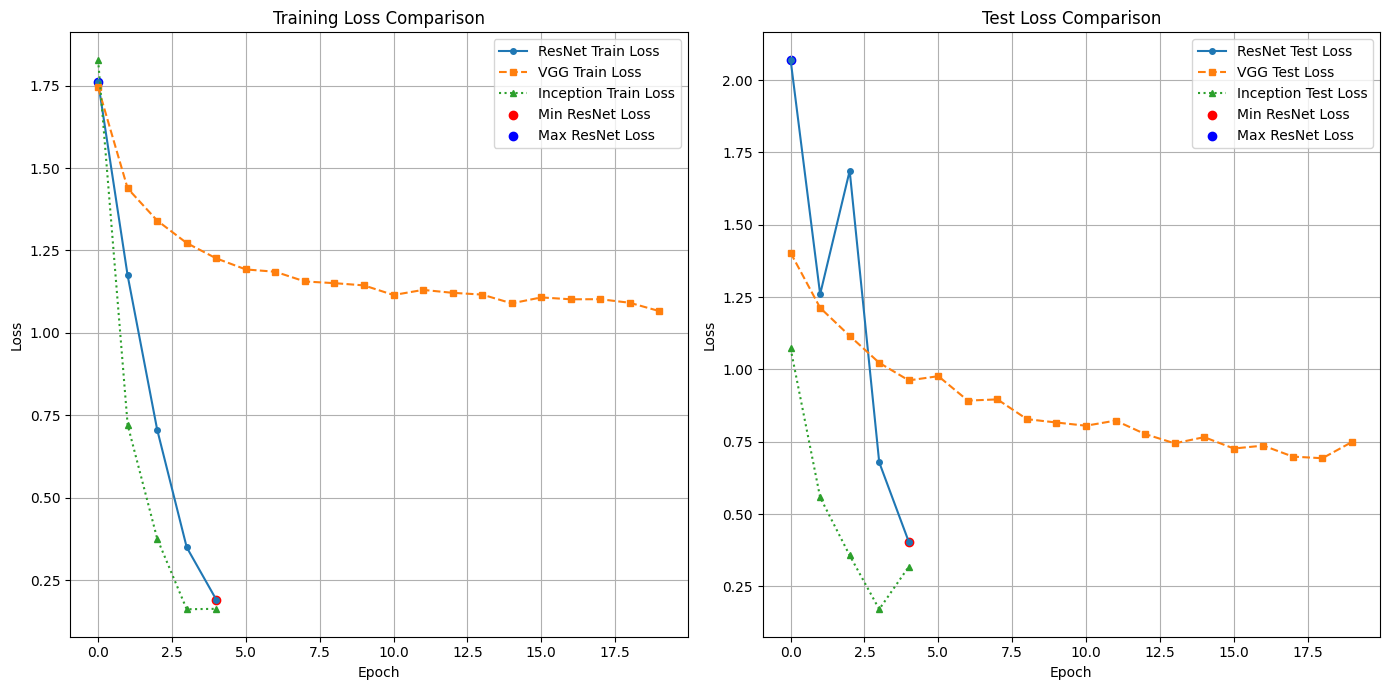

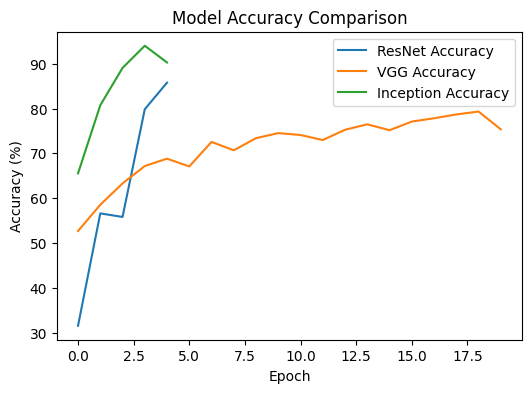

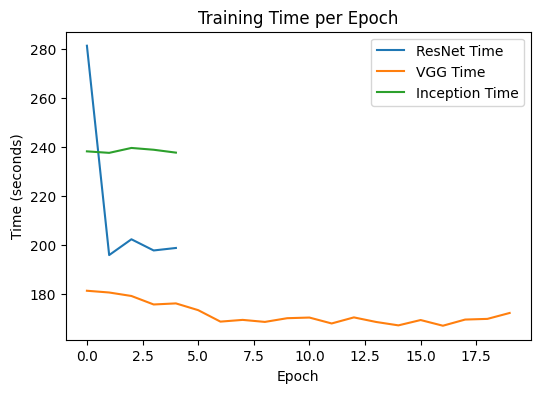

<Figure size 100000x3000 with 0 Axes>

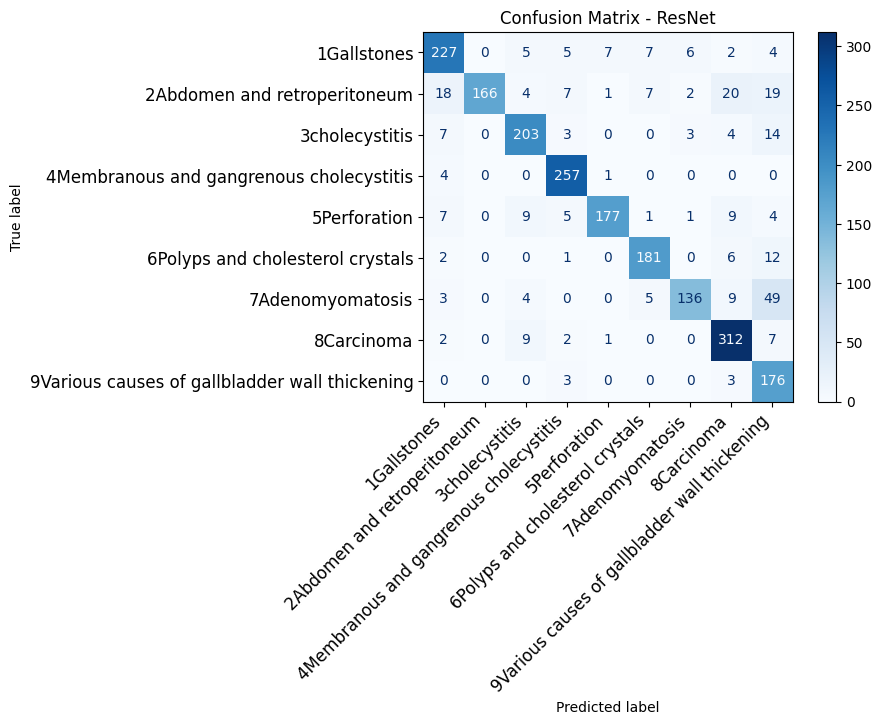

<Figure size 100000x3000 with 0 Axes>

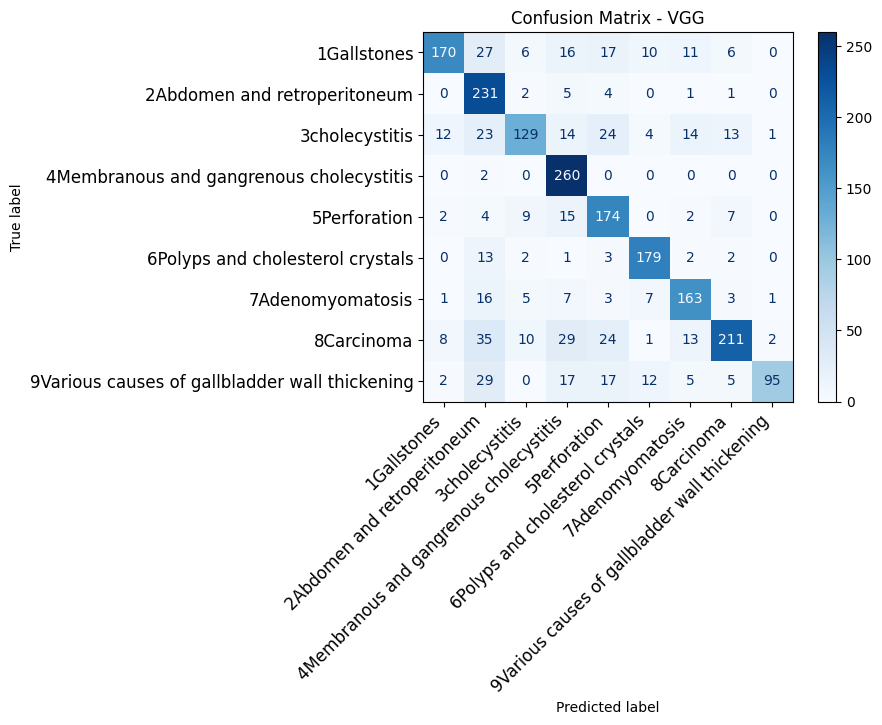

<Figure size 100000x3000 with 0 Axes>

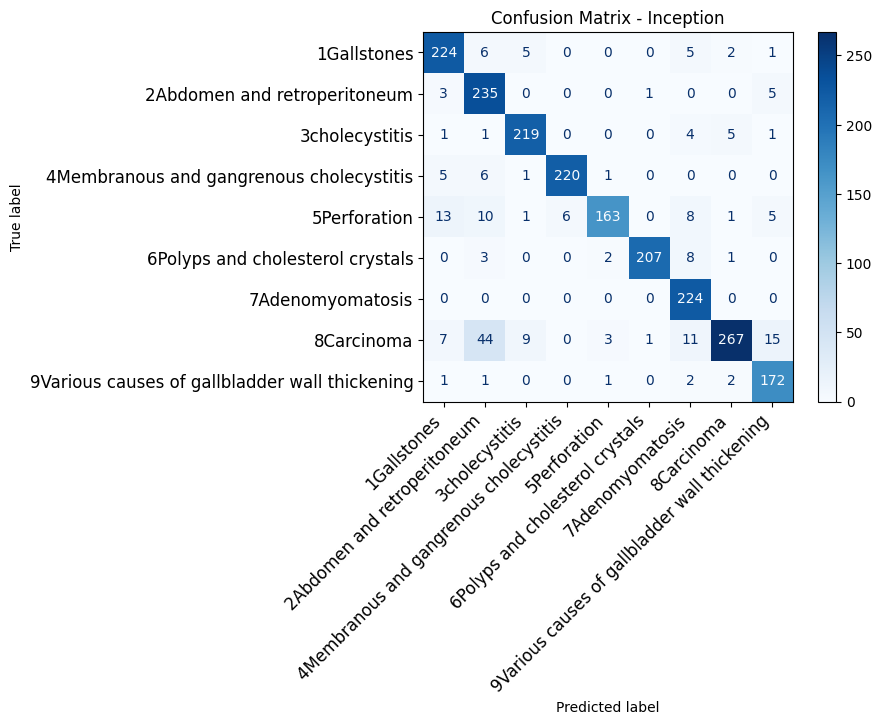

In [17]:
# Plot Losses
plot_losses(train_losses_resnet, test_losses_resnet, train_losses_vgg, test_losses_vgg, train_losses_inception, test_losses_inception)

# Plot Accuracy
plot_accuracy(test_acc_resnet, test_acc_vgg, test_acc_inception)

# Plot Time per Epoch
plot_time_per_epoch(time_resnet, time_vgg, time_inception)

# Plot Confusion Matrix for each model
plot_confusion_matrix(labels_resnet, preds_resnet, dataset.classes, "ResNet")
plot_confusion_matrix(labels_vgg, preds_vgg, dataset.classes, "VGG")
plot_confusion_matrix(labels_inception, preds_inception, dataset.classes, "Inception")


<Figure size 100000x3000 with 0 Axes>

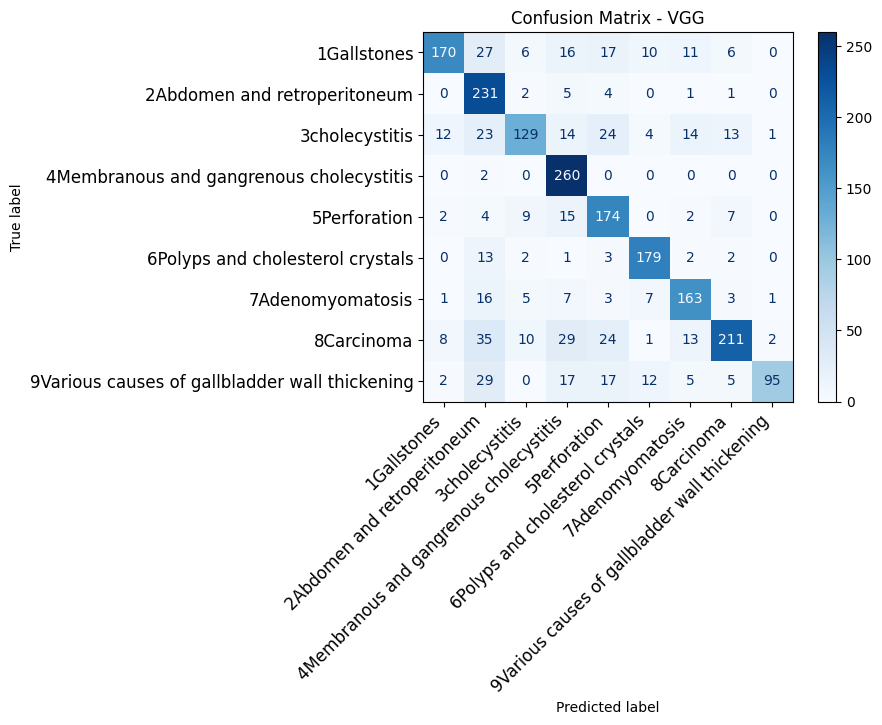

In [18]:
plot_confusion_matrix(labels_vgg, preds_vgg, dataset.classes, "VGG")


In [19]:
# print(type(vgg_result))

vgg_result['model_name']="VGG16"
resnet_resullt['model_name']="Resnet"
result_inception['model_name']="Inception"

results = [vgg_result, resnet_resullt,result_inception] 

In [20]:
# Convert results to a DataFrame
import pandas as pd

df_results = pd.DataFrame(results)

# Display the comparison table
print(df_results)


# Save the results to a CSV file
df_results.to_csv('model_comparison_results.csv', index=False)

# Later, you can load the CSV file like this
# df_results = pd.read_csv('model_comparison_results.csv')



  model_name  train_loss  test_loss   accuracy  precision    recall  f1_score  \
0      VGG16    1.066077   0.749059  75.362319   0.783605  0.753623  0.748283   
1     Resnet    0.191119   0.404283  85.787751   0.876994  0.857878  0.857789   
2  Inception    0.163223   0.317977  90.275830   0.911749  0.902758  0.902012   

   time_per_epoch  
0      171.859126  
1      215.296549  
2      238.485622  


In [21]:
from tabulate import tabulate

# Create the table using tabulate
table = tabulate(results, headers="keys", tablefmt="pretty")
print(table)


+------------+---------------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
| model_name |     train_loss      |      test_loss      |     accuracy      |     precision      |       recall       |      f1_score      |   time_per_epoch   |
+------------+---------------------+---------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|   VGG16    | 1.0660773113147537  | 0.7490591389029774  | 75.3623188405797  | 0.7836047487927009 | 0.7536231884057971 | 0.7482834957663933 | 171.85912629365922 |
|   Resnet   | 0.19111949654379443 | 0.40428325144657445 | 85.7877512856475  | 0.8769944468038866 | 0.857877512856475  | 0.8577893420038952 | 215.2965486049652  |
| Inception  | 0.16322309453797929 | 0.31797652958489175 | 90.27582982702198 | 0.9117494577950795 | 0.9027582982702197 | 0.9020117428881879 | 238.48562150001527 |
+------------+--------